In [1]:
import ultralytics
ultralytics.checks()
from ultralytics import YOLO
from PIL import Image

import torch
import yaml

import os
import random
from ultralytics.utils.plotting import plot_labels
import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt

module_path = os.path.abspath(os.path.join('..'))
print(module_path)
module_path = module_path+'/data_preprocessing'
print(module_path)

if module_path not in sys.path:
    sys.path.append(module_path)

import visualization_utils as visutils

Ultralytics YOLOv8.0.199 🚀 Python-3.11.6 torch-2.1.0+cu121 CUDA:0 (NVIDIA RTX A5000, 24248MiB)
Setup complete ✅ (32 CPUs, 251.6 GB RAM, 0.7/125.8 GB disk)


/vast/palmer/home.grace/eec42/BirdDetector/src
/vast/palmer/home.grace/eec42/BirdDetector/src/data_preprocessing


In [2]:
device = "0" if torch.cuda.is_available() else "cpu"
if device == "0":
    torch.cuda.set_device(0) # Set to your desired GPU number

print(device)

0


In [3]:
model_name = 'pfeifer_penguins_poland_yolov8m_120epoch'
model = YOLO('runs/detect/' + model_name + '/weights/best.pt')

IOU_THRESHOLD = 0.1
NB_CONF_THRESHOLDS = 50
CONF_THRESHOLDS = np.linspace(0, 1, NB_CONF_THRESHOLDS)
CONF_THRESHOLD = 0.2

In [4]:
fname = "data.yaml"
stream = open(fname, 'r')
data = yaml.safe_load(stream)
img_path = data['path'] + '/test/'
img_path

img_list = os.listdir(img_path + '/images/')

In [5]:
def box_iou(box1, box2, eps=1e-7):
    """
    Calculate intersection-over-union (IoU) of boxes. Both sets of boxes are expected to be in (x1, y1, x2, y2) format.
    Based on https://github.com/pytorch/vision/blob/master/torchvision/ops/boxes.py

    Args:
        box1 (torch.Tensor): A tensor of shape (N, 4) representing N bounding boxes.
        box2 (torch.Tensor): A tensor of shape (M, 4) representing M bounding boxes.
        eps (float, optional): A small value to avoid division by zero. Defaults to 1e-7.

    Returns:
        (torch.Tensor): An NxM tensor containing the pairwise IoU values for every element in box1 and box2.
    """

    # inter(N,M) = (rb(N,M,2) - lt(N,M,2)).clamp(0).prod(2)
    (a1, a2), (b1, b2) = box1.unsqueeze(1).chunk(2, 2), box2.unsqueeze(0).chunk(2, 2)
    inter = (torch.min(a2, b2) - torch.max(a1, b1)).clamp_(0).prod(2)

    # IoU = inter / (area1 + area2 - inter)
    return inter / ((a2 - a1).prod(2) + (b2 - b1).prod(2) - inter + eps)


In [6]:
# match_predictions method from YOLOv8 code - try to reuse it to simplify

def match_predictions(pred_classes, true_classes, iou, use_scipy=False):
    """
    Matches predictions to ground truth objects (pred_classes, true_classes) using IoU.

    Args:
        pred_classes (torch.Tensor): Predicted class indices of shape(N,).
        true_classes (torch.Tensor): Target class indices of shape(M,).
        iou (torch.Tensor): An NxM tensor containing the pairwise IoU values for predictions and ground of truth
        use_scipy (bool): Whether to use scipy for matching (more precise).

    Returns:
        (torch.Tensor): Correct tensor of shape(N,1) for 1 IoU thresholds.
    """
    # Dx10 matrix, where D - detections, 10 - IoU thresholds
    correct = np.zeros((pred_classes.shape[0], 1)).astype(bool)
    # LxD matrix where L - labels (rows), D - detections (columns)
    correct_class = true_classes[:, None] == pred_classes
    iou = iou * correct_class  # zero out the wrong classes
    iou = iou.cpu().numpy()
    threshold = IOU_THRESHOLD
    #for i, threshold in enumerate(self.iouv.cpu().tolist()):
    if use_scipy:
        # WARNING: known issue that reduces mAP in https://github.com/ultralytics/ultralytics/pull/4708
        import scipy  # scope import to avoid importing for all commands
        cost_matrix = iou * (iou >= threshold)
        if cost_matrix.any():
            labels_idx, detections_idx = scipy.optimize.linear_sum_assignment(cost_matrix, maximize=True)
            valid = cost_matrix[labels_idx, detections_idx] > 0
            if valid.any():
                correct[detections_idx[valid]] = True
    else:
        matches = np.nonzero(iou >= threshold)  # IoU > threshold and classes match
        matches = np.array(matches).T
        if matches.shape[0]:
            if matches.shape[0] > 1:
                matches = matches[iou[matches[:, 0], matches[:, 1]].argsort()[::-1]]
                matches = matches[np.unique(matches[:, 1], return_index=True)[1]]
                # matches = matches[matches[:, 2].argsort()[::-1]]
                matches = matches[np.unique(matches[:, 0], return_index=True)[1]]
            correct[matches[:, 1].astype(int)] = True
    return torch.tensor(correct, dtype=torch.bool, device=pred_classes.device)


In [8]:
#img_list = random.choices(os.listdir(img_path + '/images/'), k=1)

# Retrieve TP, FP, FN metrics

In [7]:
# tensors to store metrics: each line is a confidence threshold, columns are images
TP = torch.zeros((NB_CONF_THRESHOLDS, len(img_list)), dtype=torch.float32)
FN = torch.zeros((NB_CONF_THRESHOLDS, len(img_list)), dtype=torch.float32)
FP = torch.zeros((NB_CONF_THRESHOLDS, len(img_list)), dtype=torch.float32)


for conf_i, conf_threshold in enumerate(CONF_THRESHOLDS):

    for img_i, img in enumerate(img_list):

        # Apply model
        result = model.predict(
            #model = 'runs/detect/pfeifer_yolov8n_70epoch_default_batch32_dropout0.3',
            source = [os.path.join(img_path + 'images/', img)],
            conf = conf_threshold, 
            iou = IOU_THRESHOLD,
            show=False,
            save=False
        )[0]

        pred_classes = result.boxes.cls.cpu()
        pred_bboxes = result.boxes.xyxyn.cpu()

        #print("NB of predictions: ", len(pred_bboxes))

        # TODO: see if there's no easier way to read true labels, maybe take a yolov8 method
        selected_label = img_path + 'labels/' + os.path.basename(result.path).split('.jpg')[0] + '.txt'
        true_bboxes = torch.tensor([], dtype=torch.float32)
        true_classes = torch.tensor([], dtype=torch.float32)
        df = pd.read_csv(selected_label, sep='\t', header=None, index_col=False)
        for irow, row in df.iterrows():  
            true_classes = torch.cat((true_classes, torch.tensor([row[0]], dtype=torch.float32)), 0)
            true_bboxes = torch.cat((true_bboxes, torch.tensor([[row[1]-row[3]/2, row[2]-row[4]/2, row[1]+row[3]/2, row[2]+row[4]/2]], dtype=torch.float32)), 0)

        #print("NB of labels: ", len(true_bboxes))
        
        iou = box_iou(true_bboxes, pred_bboxes)
        correct = match_predictions(pred_classes, true_classes, iou)  # what they call tp in the code !!!!

        img_TP = correct.sum()
        img_FN = len(true_bboxes) - img_TP
        img_FP = len(pred_bboxes) - img_TP

        TP[conf_i, img_i] = (img_TP)
        FN[conf_i, img_i] = (img_FN)
        FP[conf_i, img_i] = (img_FP)





0: 640x640 300 birds, 6.0ms
Speed: 4.7ms preprocess, 6.0ms inference, 274.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 270 birds, 6.1ms
Speed: 1.9ms preprocess, 6.1ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 300 birds, 6.0ms
Speed: 0.9ms preprocess, 6.0ms inference, 3.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 290 birds, 6.0ms
Speed: 1.6ms preprocess, 6.0ms inference, 3.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 300 birds, 6.0ms
Speed: 1.7ms preprocess, 6.0ms inference, 3.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 288 birds, 6.0ms
Speed: 1.7ms preprocess, 6.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 244 birds, 6.0ms
Speed: 1.6ms preprocess, 6.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 293 birds, 6.0ms
Speed: 1.7ms preprocess, 6.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640

# Plot Precision, Recall and PR curves

In [8]:
final_TP = torch.sum(TP, dim=1)
final_FN = torch.sum(FN, dim=1)
final_FP = torch.sum(FP, dim=1)

In [9]:
len(TP)

50

In [10]:
final_TP

tensor([1.8737e+04, 1.7941e+04, 1.7610e+04, 1.7405e+04, 1.7194e+04, 1.6984e+04, 1.6795e+04, 1.6632e+04, 1.6436e+04, 1.6237e+04, 1.6006e+04, 1.5787e+04, 1.5512e+04, 1.5187e+04, 1.4809e+04, 1.4368e+04, 1.3861e+04, 1.3360e+04, 1.2847e+04, 1.2186e+04, 1.1416e+04, 1.0512e+04, 9.3590e+03, 7.8410e+03, 6.0180e+03, 4.1100e+03,
        2.6190e+03, 1.6720e+03, 1.1050e+03, 7.5700e+02, 4.8100e+02, 2.4200e+02, 8.4000e+01, 2.0000e+01, 2.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00])

In [11]:
precision = final_TP / (final_TP + final_FP)
recall = final_TP / (final_TP + final_FN)

In [12]:
recall

tensor([9.9819e-01, 9.5578e-01, 9.3815e-01, 9.2723e-01, 9.1599e-01, 9.0480e-01, 8.9473e-01, 8.8605e-01, 8.7561e-01, 8.6500e-01, 8.5270e-01, 8.4103e-01, 8.2638e-01, 8.0907e-01, 7.8893e-01, 7.6544e-01, 7.3843e-01, 7.1174e-01, 6.8441e-01, 6.4919e-01, 6.0817e-01, 5.6001e-01, 4.9859e-01, 4.1772e-01, 3.2060e-01, 2.1895e-01,
        1.3952e-01, 8.9074e-02, 5.8867e-02, 4.0328e-02, 2.5625e-02, 1.2892e-02, 4.4750e-03, 1.0655e-03, 1.0655e-04, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00])

In [13]:
len(recall)

50

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


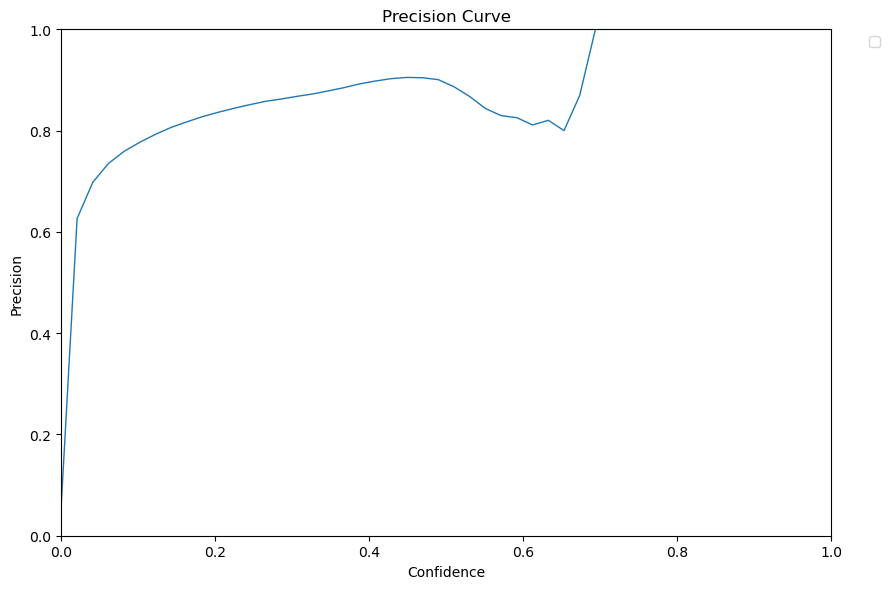

In [22]:
py = precision
px = CONF_THRESHOLDS
save_dir = '/vast/palmer/home.grace/eec42/BirdDetector/src/model/runs/detect/' + model_name + '/custom_P_curve.jpg'

fig, ax = plt.subplots(1, 1, figsize=(9, 6), tight_layout=True)
#py = np.stack(py, axis=1)

#for i, y in enumerate(py.T):
ax.plot(px, py, linewidth=1) #, label=f'{names[i]} {ap[i, 0]:.3f}')  # plot(recall, precision)

#ax.plot(px, py.mean(1), linewidth=3, color='blue', label='all classes %.3f mAP@0.5' % ap[:, 0].mean())
ax.set_xlabel('Confidence')
ax.set_ylabel('Precision')
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.legend(bbox_to_anchor=(1.04, 1), loc='upper left')
ax.set_title('Precision Curve')
fig.savefig(save_dir, dpi=250)
plt.show()
plt.close(fig)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


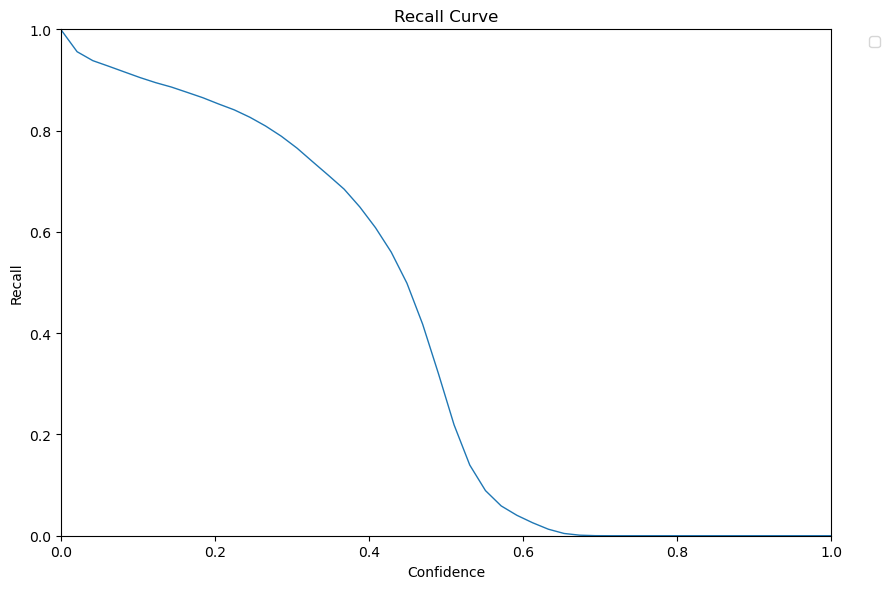

In [23]:
py = recall
px = CONF_THRESHOLDS
save_dir = '/vast/palmer/home.grace/eec42/BirdDetector/src/model/runs/detect/' + model_name + '/custom_R_curve.jpg'

fig, ax = plt.subplots(1, 1, figsize=(9, 6), tight_layout=True)
#py = np.stack(py, axis=1)

#for i, y in enumerate(py.T):
ax.plot(px, py, linewidth=1) #, label=f'{names[i]} {ap[i, 0]:.3f}')  # plot(recall, precision)

#ax.plot(px, py.mean(1), linewidth=3, color='blue', label='all classes %.3f mAP@0.5' % ap[:, 0].mean())
ax.set_xlabel('Confidence')
ax.set_ylabel('Recall')
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.legend(bbox_to_anchor=(1.04, 1), loc='upper left')
ax.set_title('Recall Curve')
fig.savefig(save_dir, dpi=250)
plt.show()
plt.close(fig)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


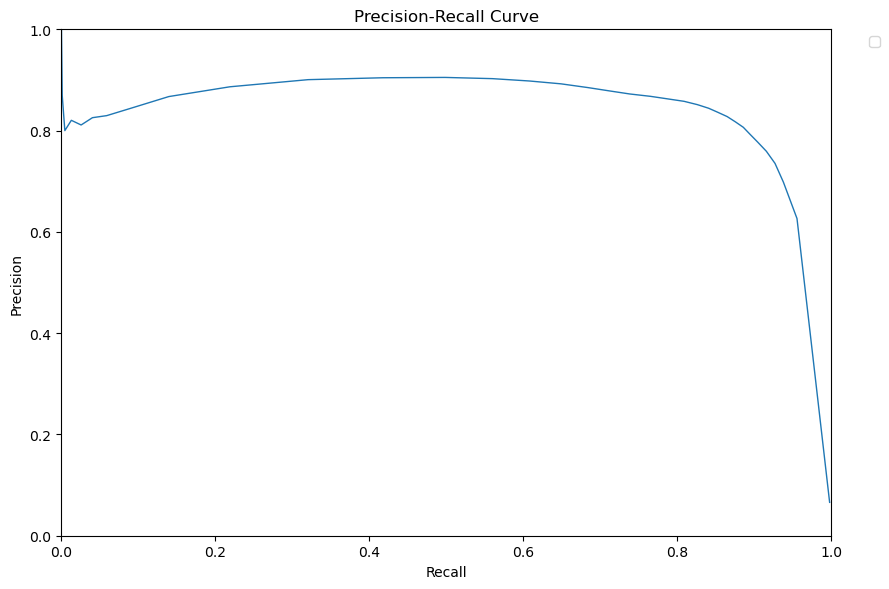

In [24]:
py = precision
px = recall

save_path = '/vast/palmer/home.grace/eec42/BirdDetector/src/model/runs/detect/' + model_name + '/custom_PR_curve.jpg'


fig, ax = plt.subplots(1, 1, figsize=(9, 6), tight_layout=True)
#py = np.stack(py, axis=1)

#for i, y in enumerate(py.T):
ax.plot(px, py, linewidth=1) #, label=f'{names[i]} {ap[i, 0]:.3f}')  # plot(recall, precision)

#ax.plot(px, py.mean(1), linewidth=3, color='blue', label='all classes %.3f mAP@0.5' % ap[:, 0].mean())
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.legend(bbox_to_anchor=(1.04, 1), loc='upper left')
ax.set_title('Precision-Recall Curve')
fig.savefig(save_path, dpi=250)
plt.show()
plt.close(fig)
